In [2]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import math
import seaborn as sns

from util import *

Text(0.5, 1.0, 'Ground Truth')

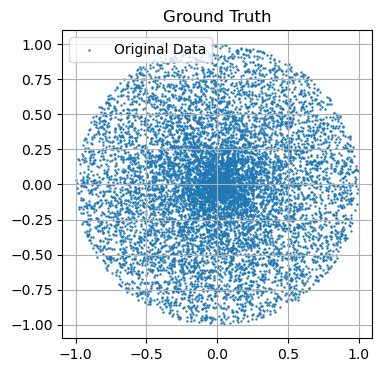

In [3]:
r = np.random.uniform(low = 0,high = 1, size = 10000)
theta = np.random.uniform(low = 0,high = 2*np.pi, size = 10000)
X = r*np.cos(theta)
Y = r*np.sin(theta)


Data_original = np.concatenate([X[:,None],Y[:,None]],axis = -1)

plt.figure(figsize=(4,4))
plt.scatter(Data_original[:,0],Data_original[:,1], s= 0.5, label = "Original Data")
plt.grid("True")
plt.legend()
plt.title("Ground Truth")

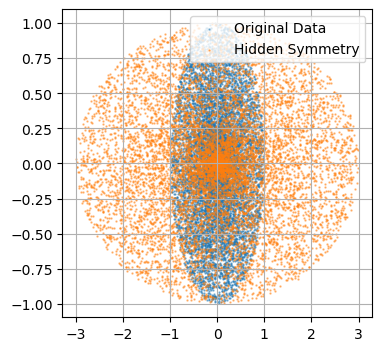

In [4]:
X_new = 3*(X.copy()) # Coordinate Perturbation
Y_new = Y.copy() # Coordinate Perturbation
Data_perturbed = np.concatenate([X_new[:,None],Y_new[:,None]],axis = -1)

plt.figure(figsize=(4,4))
plt.scatter(Data_original[:,0],Data_original[:,1], s= 0.5, label = "Original Data", alpha = 0.5)
plt.scatter(Data_perturbed[:,0],Data_perturbed[:,1], s= 0.5, label = "Hidden Symmetry", alpha = 0.5)
plt.grid("True")
plt.legend(loc = "upper right")

In [5]:
def psi(z):
    """
    The conserved charge in the new coordinate system
    """
    X_old_square = ((z[:,0]/3)**2)
    Y_old_square = (z[:,1])**2
    
    return ( (X_old_square+Y_old_square) **0.5)[:,None]

In [6]:
# Complete supervised train technique
tensor_original = torch.Tensor(Data_original)
tensor_perturbed = torch.Tensor(Data_perturbed)

dataset = torch.utils.data.TensorDataset(tensor_original, tensor_perturbed)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataloader = DataLoader(test_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

device = "cuda:0"

In [7]:
NUM_GEN = 1
model_symmetry = Operator(feature_size=2,
                          feature_multipier=4,
                          number_of_blocks=4,
                          num_generators=NUM_GEN,
                          normalise_enc=True,
                          normalise_dec=False,
                          LOSS_MODE="MSE"
                         ).to(device)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)
# optimiser_symmetry = torch.optim.SGD(model_symmetry.parameters(), lr = 0.01)
scheduler_symmetry = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser_symmetry, mode='min', factor=0.1, patience=10, verbose=True)



/global/homes/d/diptarko/.local/perlmutter/tensorflow2.12.0/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 0 complete
Symmetry Closure Loss  0.2866328040758769
Symmetry Orthogonality Loss  0
Symmetry Collapse Loss  0.9088263273239136
Space Inversion Loss  0.8330289920171102
Total loss 2.0284881234169005


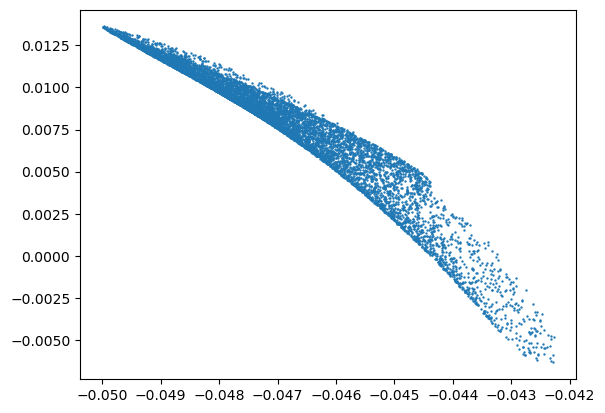

EPOCH 100 complete
Symmetry Closure Loss  0.0013989763179173072
Symmetry Orthogonality Loss  0
Symmetry Collapse Loss  0.00014309932788213094
Space Inversion Loss  0.0002765161518861229
Total loss 0.001818591797685561


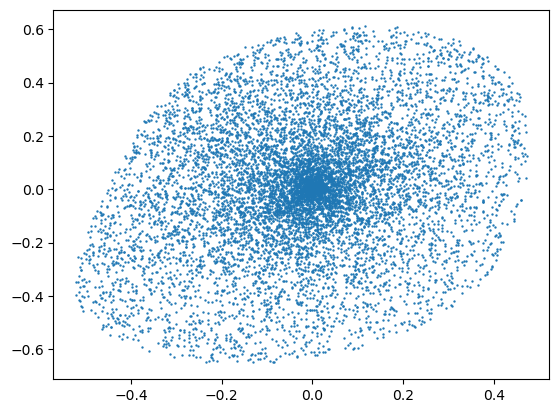

EPOCH 200 complete
Symmetry Closure Loss  0.00019022517371922732
Symmetry Orthogonality Loss  0
Symmetry Collapse Loss  0.00012178818384806315
Space Inversion Loss  5.7292798980294414e-05
Total loss 0.0003693061565475849


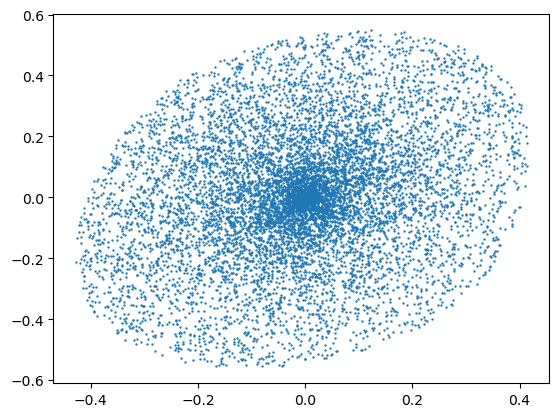

EPOCH 300 complete
Symmetry Closure Loss  3.296686603183237e-05
Symmetry Orthogonality Loss  0
Symmetry Collapse Loss  0.00011513034502665201
Space Inversion Loss  2.6092235081402275e-05
Total loss 0.00017418944613988667


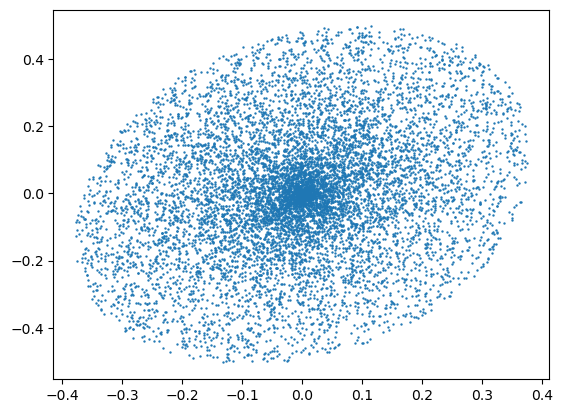

EPOCH 400 complete
Symmetry Closure Loss  9.656645003512191e-06
Symmetry Orthogonality Loss  0
Symmetry Collapse Loss  0.00011410216490427653
Space Inversion Loss  1.2650031082254525e-05
Total loss 0.00013640884099004326


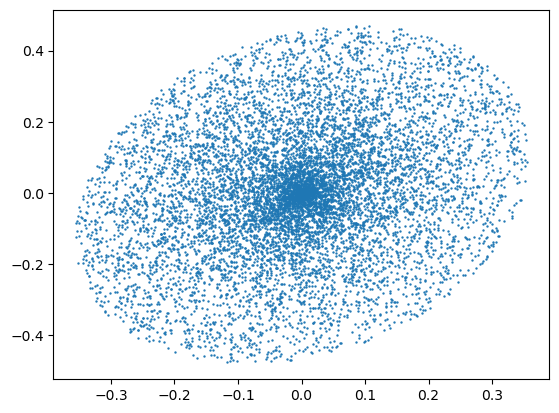

EPOCH 500 complete
Symmetry Closure Loss  6.147122864301006e-06
Symmetry Orthogonality Loss  0
Symmetry Collapse Loss  0.00011426558097203573
Space Inversion Loss  1.2168294627675399e-05
Total loss 0.00013258099846401213


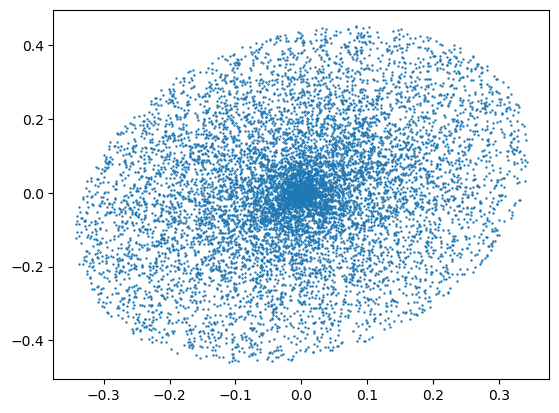

EPOCH 600 complete
Symmetry Closure Loss  4.981454079218869e-06
Symmetry Orthogonality Loss  0
Symmetry Collapse Loss  0.00011532207330067952
Space Inversion Loss  5.468376245213828e-06
Total loss 0.00012577190362511224


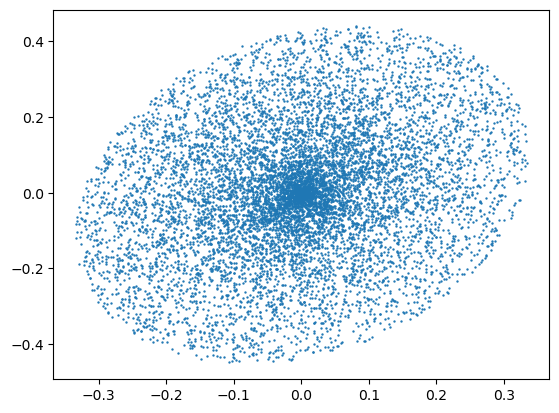

EPOCH 700 complete
Symmetry Closure Loss  3.959788803816385e-06
Symmetry Orthogonality Loss  0
Symmetry Collapse Loss  0.00011538217465082805
Space Inversion Loss  6.564096505220126e-06
Total loss 0.00012590605995986456


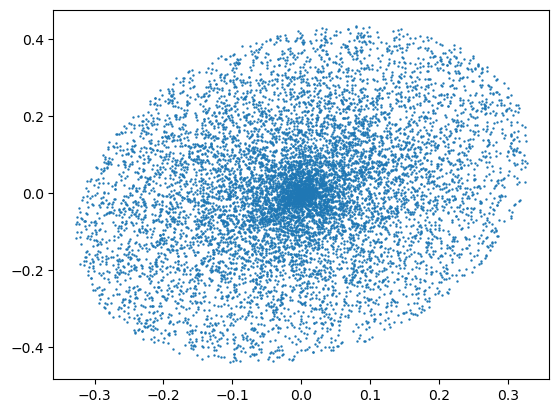

EPOCH 800 complete
Symmetry Closure Loss  3.584581266598737e-06
Symmetry Orthogonality Loss  0
Symmetry Collapse Loss  0.0001149629553159078
Space Inversion Loss  6.003563673099658e-06
Total loss 0.0001245511002556062


In [ ]:
model_symmetry = train_for_hidden_symmetry(train_dataloader = train_dataloader,
                                           visualisation_set = tensor_perturbed,
                                           optimiser_symmetry = optimiser_symmetry,
                                           model_symmetry = model_symmetry,
                                           psi = psi,
                                           NUM_GEN = NUM_GEN,
                                           device = device,
                                           verbose= True,
                                           NEpochs = 1000,
                             )

### Looking at specific examples

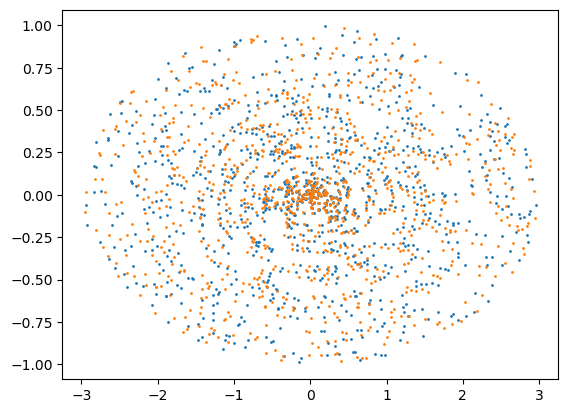

In [16]:
perturbed = tensor_perturbed[:1024,:].to(device)
theta = [(0.05*torch.ones(perturbed.shape[0],device = device)) for i in range(NUM_GEN)]  #Sampling

enc, trans, dec, dec_trans = model_symmetry(Z = perturbed,
                                            theta = theta)

original = perturbed.to("cpu").detach()
transformed = dec_trans.to("cpu").detach()

plt.scatter(original[:,0],original[:,1],s=1)
plt.scatter(transformed[:,0],transformed[:,1],s=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


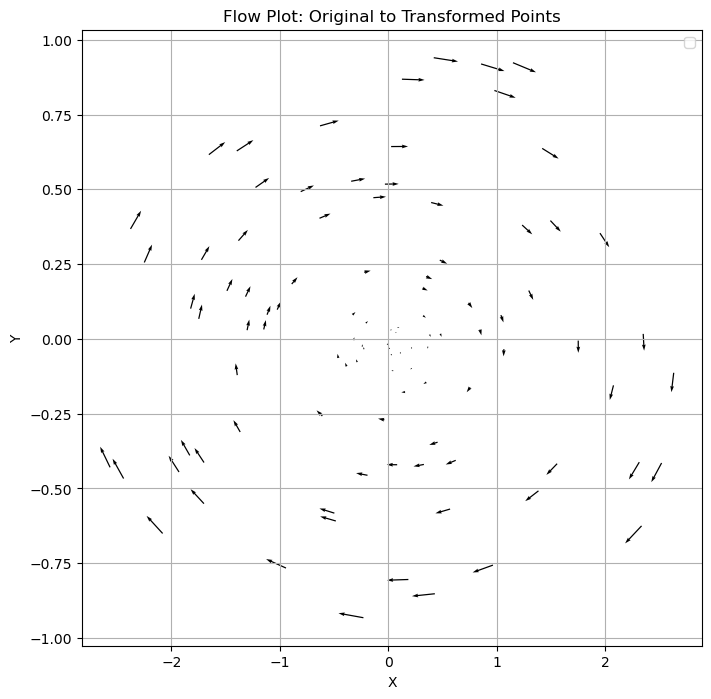

In [17]:
plt.figure(figsize=(8, 8))
magni = 1
dx = transformed[:100, 0] - original[:100, 0]
dy = transformed[:100, 1] - original[:100, 1]
plt.quiver(original[:100, 0], original[:100, 1], magni*dx, magni*dy, angles='xy', scale_units='xy', scale=1, width=0.002, alpha=1, color='black')

plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Flow Plot: Original to Transformed Points")
# plt.axis('equal')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


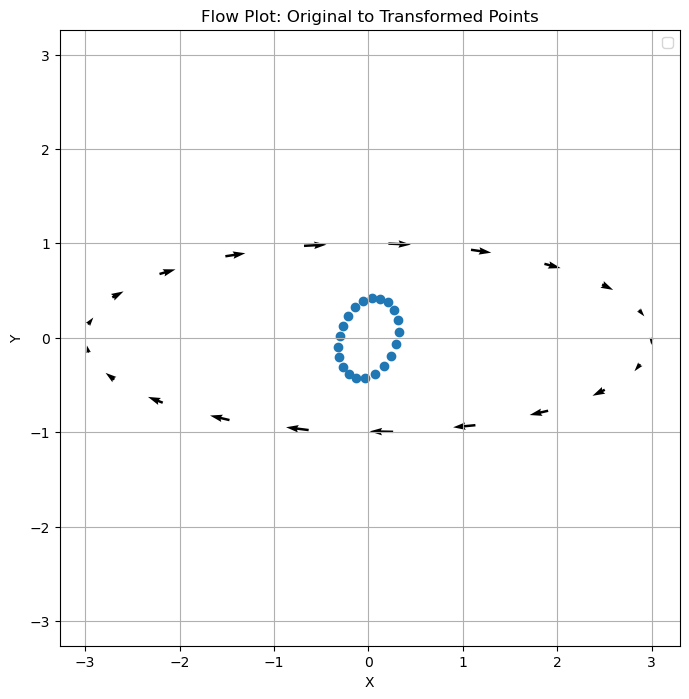

In [18]:
r = 1
theta = np.arange(0,2*np.pi,0.3)
X = r*np.cos(theta)
Y = r*np.sin(theta)

X_new = 3*(X.copy()) # Coordinate Perturbation
Y_new = Y.copy() # Coordinate Perturbation
Data_vis = torch.Tensor(np.concatenate([X_new[:,None],Y_new[:,None]],axis = -1))


theta = [(0.05*torch.ones(Data_vis.shape[0],device = device)) for i in range(NUM_GEN)]  #Sampling

enc, trans, dec, dec_trans = model_symmetry(Z = Data_vis.to(device),
                                            theta = theta)

original = Data_vis.detach()
transformed = dec_trans.to("cpu").detach()


plt.figure(figsize=(8, 8))
magni = 1
dx = transformed[:, 0] - original[:, 0]
dy = transformed[:, 1] - original[:, 1]
plt.quiver(original[:, 0], original[:, 1], magni*dx, magni*dy, angles='xy', scale_units='xy', scale=1, width=0.004, alpha=1, color='black')
plt.scatter(enc[:,0].detach().cpu(),enc[:,1].detach().cpu())
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Flow Plot: Original to Transformed Points")
plt.axis('equal')
plt.grid(True)
plt.show()